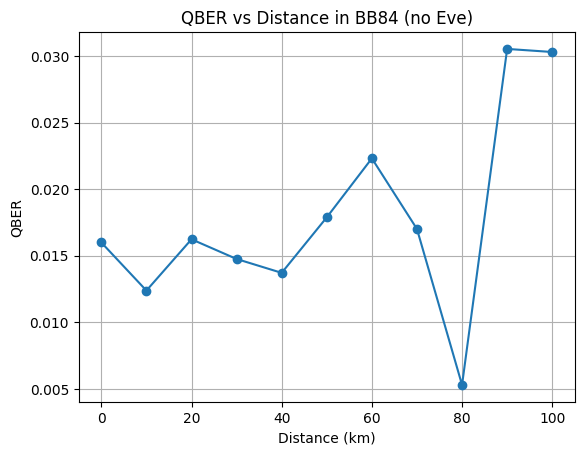

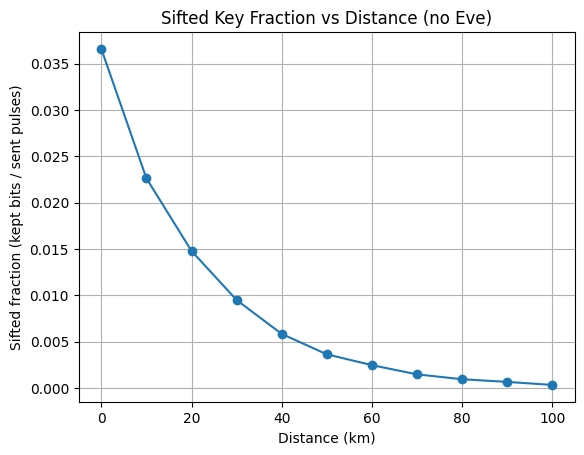

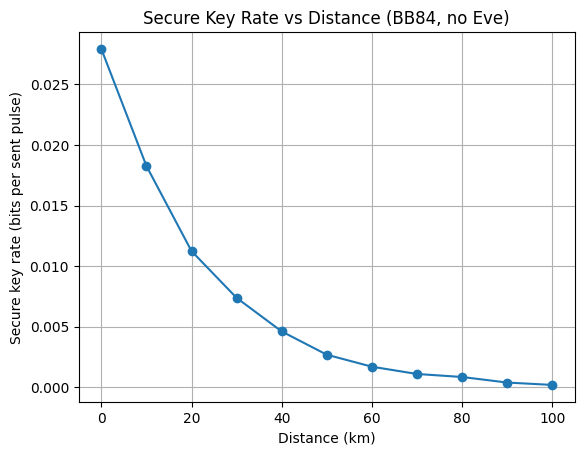

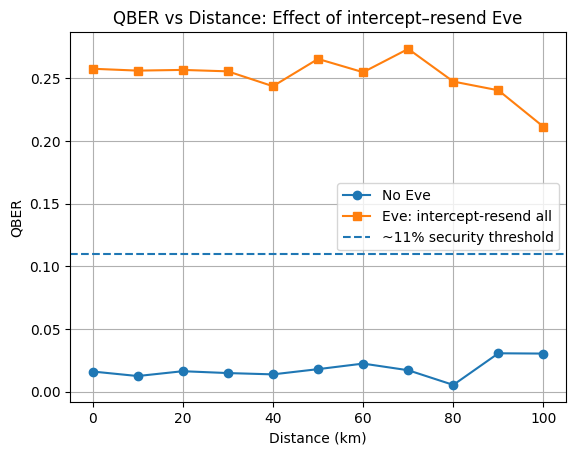

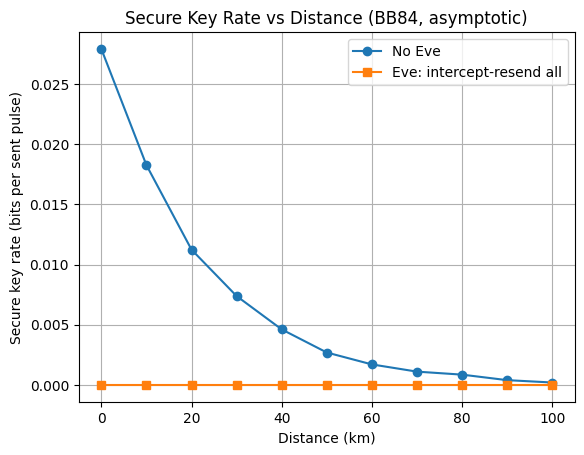

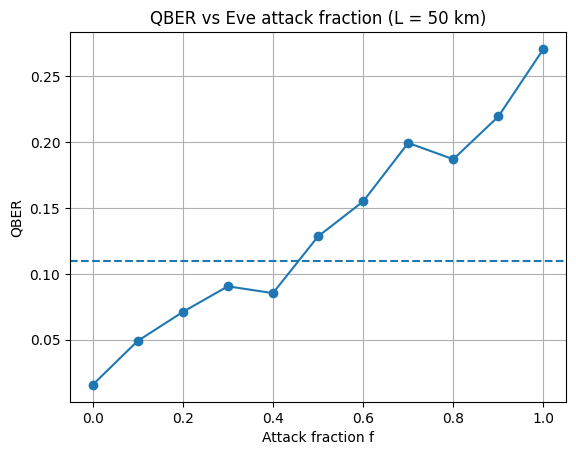

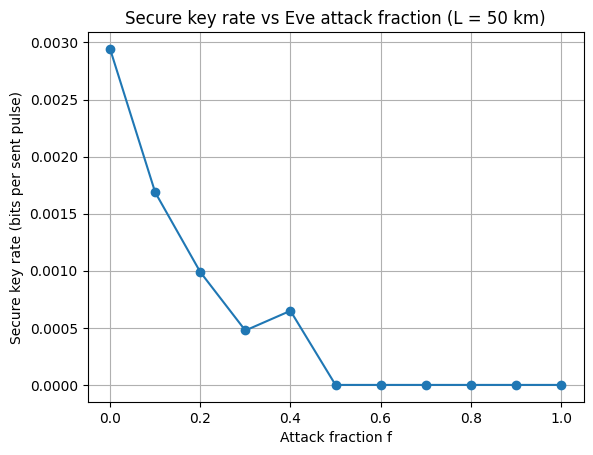

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# 0. ตั้งค่าทั่วไป
# ==============================
rng = np.random.default_rng(42)

# พารามิเตอร์ระบบ
N_PULSES       = 200000   # จำนวน pulse ต่อการจำลอง 1 จุด
MU             = 0.5      # mean photon number / pulse
ALPHA_DB_KM    = 0.2      # loss ใยแก้ว (dB/km)
DET_EFF        = 0.15     # detector efficiency
DARK_PROB      = 1e-6     # dark count ต่อ pulse
MISALIGN_ERROR = 0.015    # alignment error ~1.5%

DISTANCES = np.linspace(0, 100, 11)  # 0,10,...,100 km


# ==============================
# 1. ฟังก์ชันช่วย
# ==============================

def binary_entropy(x):
    """Binary entropy h(x) (ระวัง log(0) เลย clip ค่าเล็กน้อย)"""
    x = np.clip(x, 1e-12, 1 - 1e-12)
    return -x * np.log2(x) - (1 - x) * np.log2(1 - x)


def simulate_bb84(L_km, with_eve=False):
    """
    จำลอง BB84 ระยะ L_km
    with_eve = False  -> ไม่มี Eve
    with_eve = True   -> Eve intercept–resend ทุก pulse
    """
    # ---- channel ----
    transmittance = 10 ** (-ALPHA_DB_KM * L_km / 10)
    p_signal = 1 - np.exp(-MU * transmittance * DET_EFF)
    p_det    = p_signal + DARK_PROB

    # ---- random choices ----
    alice_bits  = rng.integers(0, 2, N_PULSES)
    alice_bases = rng.integers(0, 2, N_PULSES)  # 0=Z, 1=X
    bob_bases   = rng.integers(0, 2, N_PULSES)

    detections = rng.random(N_PULSES) < p_det
    bob_bits   = rng.integers(0, 2, N_PULSES)   # init random

    # สัดส่วน detection จาก signal vs dark
    with np.errstate(divide='ignore', invalid='ignore'):
        p_signal_given_det = np.where(p_det > 0, p_signal / p_det, 0.0)
    signal_detection = (rng.random(N_PULSES) < p_signal_given_det) & detections
    dark_detection   = detections & (~signal_detection)

    error_flip = rng.random(N_PULSES) < MISALIGN_ERROR

    if not with_eve:
        # ---------- ไม่มี Eve ----------
        mask_signal_correct_basis = signal_detection & (alice_bases == bob_bases)
        bob_bits[mask_signal_correct_basis] = (
            alice_bits[mask_signal_correct_basis] ^
            error_flip[mask_signal_correct_basis]
        )
        # mismatched basis + dark = random (ปล่อยไว้)
    else:
        # ---------- Eve intercept–resend ทุก pulse ----------
        eve_bases = rng.integers(0, 2, N_PULSES)
        eve_bits  = rng.integers(0, 2, N_PULSES)

        mask_eve_correct_basis = eve_bases == alice_bases
        eve_bits[mask_eve_correct_basis] = alice_bits[mask_eve_correct_basis]

        # Bob เห็นโฟตอนจาก Eve
        mask_signal_correct_basis = signal_detection & (eve_bases == bob_bases)
        bob_bits[mask_signal_correct_basis] = (
            eve_bits[mask_signal_correct_basis] ^
            error_flip[mask_signal_correct_basis]
        )

    # ---- sifting (ดูเฉพาะ event ที่ตรวจจับ + basis ตรงกัน) ----
    sift_mask = detections & (alice_bases == bob_bases)
    sifted_alice = alice_bits[sift_mask]
    sifted_bob   = bob_bits[sift_mask]

    if len(sifted_alice) == 0:
        qber      = 0.5
        sift_frac = 0.0
        key_rate  = 0.0
    else:
        qber      = np.mean(sifted_alice != sifted_bob)
        sift_frac = len(sifted_alice) / N_PULSES
        R         = sift_frac * max(0.0, 1 - 2 * binary_entropy(qber))
        key_rate  = R

    return qber, sift_frac, key_rate


def simulate_bb84_fraction(L_km, attack_fraction=0.0):
    """
    BB84 ระยะ L_km
    attack_fraction f: ความน่าจะเป็นที่ Eve intercept–resend pulse นั้น
    """
    # ---- channel ----
    transmittance = 10 ** (-ALPHA_DB_KM * L_km / 10)
    p_signal = 1 - np.exp(-MU * transmittance * DET_EFF)
    p_det    = p_signal + DARK_PROB

    alice_bits  = rng.integers(0, 2, N_PULSES)
    alice_bases = rng.integers(0, 2, N_PULSES)
    bob_bases   = rng.integers(0, 2, N_PULSES)

    detections = rng.random(N_PULSES) < p_det
    bob_bits   = rng.integers(0, 2, N_PULSES)

    with np.errstate(divide='ignore', invalid='ignore'):
        p_signal_given_det = np.where(p_det > 0, p_signal / p_det, 0.0)
    signal_detection = (rng.random(N_PULSES) < p_signal_given_det) & detections
    dark_detection   = detections & (~signal_detection)

    # Eve เลือกโจมตีด้วยความน่าจะเป็น f
    eve_attacks = rng.random(N_PULSES) < attack_fraction

    error_flip = rng.random(N_PULSES) < MISALIGN_ERROR

    # Eve วัดตอนที่โจมตีเท่านั้น
    eve_bases = rng.integers(0, 2, N_PULSES)
    eve_bits  = rng.integers(0, 2, N_PULSES)
    mask_eve_correct_basis = eve_bases == alice_bases
    eve_bits[mask_eve_correct_basis] = alice_bits[mask_eve_correct_basis]

    # pulse ที่ Bob เห็น signal จาก Eve
    mask_signal_eve    = signal_detection & eve_attacks
    # pulse ที่ Bob เห็น signal จาก Alice โดยตรง
    mask_signal_direct = signal_detection & (~eve_attacks)

    # เคส Eve → basis Eve = Bob
    mask_signal_eve_correct = mask_signal_eve & (eve_bases == bob_bases)
    bob_bits[mask_signal_eve_correct] = (
        eve_bits[mask_signal_eve_correct] ^
        error_flip[mask_signal_eve_correct]
    )

    # เคส direct → basis Alice = Bob
    mask_signal_direct_correct = mask_signal_direct & (alice_bases == bob_bases)
    bob_bits[mask_signal_direct_correct] = (
        alice_bits[mask_signal_direct_correct] ^
        error_flip[mask_signal_direct_correct]
    )

    # sifting
    sift_mask = detections & (alice_bases == bob_bases)
    sifted_alice = alice_bits[sift_mask]
    sifted_bob   = bob_bits[sift_mask]

    if len(sifted_alice) == 0:
        qber      = 0.5
        sift_frac = 0.0
        key_rate  = 0.0
    else:
        qber      = np.mean(sifted_alice != sifted_bob)
        sift_frac = len(sifted_alice) / N_PULSES
        R         = sift_frac * max(0.0, 1 - 2 * binary_entropy(qber))
        key_rate  = R

    return qber, sift_frac, key_rate


# ==============================
# 2. baseline: ไม่มี Eve
# ==============================
qbers_no_eve   = []
sift_no_eve    = []
keyrate_no_eve = []

for L in DISTANCES:
    q, s, k = simulate_bb84(L, with_eve=False)
    qbers_no_eve.append(q)
    sift_no_eve.append(s)
    keyrate_no_eve.append(k)

qbers_no_eve   = np.array(qbers_no_eve)
sift_no_eve    = np.array(sift_no_eve)
keyrate_no_eve = np.array(keyrate_no_eve)

# --- plot baseline ---
plt.figure()
plt.plot(DISTANCES, qbers_no_eve, marker='o')
plt.xlabel("Distance (km)")
plt.ylabel("QBER")
plt.title("QBER vs Distance in BB84 (no Eve)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(DISTANCES, sift_no_eve, marker='o')
plt.xlabel("Distance (km)")
plt.ylabel("Sifted fraction (kept bits / sent pulses)")
plt.title("Sifted Key Fraction vs Distance (no Eve)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(DISTANCES, keyrate_no_eve, marker='o')
plt.xlabel("Distance (km)")
plt.ylabel("Secure key rate (bits per sent pulse)")
plt.title("Secure Key Rate vs Distance (BB84, no Eve)")
plt.grid(True)
plt.show()


# ==============================
# 3. Eve intercept–resend ทุก pulse
# ==============================
qber_eve_full   = []
keyrate_eve_full= []

for L in DISTANCES:
    q, s, k = simulate_bb84(L, with_eve=True)
    qber_eve_full.append(q)
    keyrate_eve_full.append(k)

qber_eve_full    = np.array(qber_eve_full)
keyrate_eve_full = np.array(keyrate_eve_full)

# --- plot QBER with/without Eve ---
plt.figure()
plt.plot(DISTANCES, qbers_no_eve,   marker='o', label="No Eve")
plt.plot(DISTANCES, qber_eve_full,  marker='s', label="Eve: intercept-resend all")
plt.axhline(0.11, linestyle='--', label="~11% security threshold")
plt.xlabel("Distance (km)")
plt.ylabel("QBER")
plt.title("QBER vs Distance: Effect of intercept–resend Eve")
plt.grid(True)
plt.legend()
plt.show()

# --- plot key rate with/without Eve ---
plt.figure()
plt.plot(DISTANCES, keyrate_no_eve,   marker='o', label="No Eve")
plt.plot(DISTANCES, keyrate_eve_full, marker='s', label="Eve: intercept-resend all")
plt.xlabel("Distance (km)")
plt.ylabel("Secure key rate (bits per sent pulse)")
plt.title("Secure Key Rate vs Distance (BB84, asymptotic)")
plt.grid(True)
plt.legend()
plt.show()


# ==============================
# 4. Eve ดักบางส่วน: attack_fraction
# ==============================
L_FIXED = 50.0                         # ระยะที่ fix ไว้
fractions = np.linspace(0, 1, 11)      # f = 0,0.1,...,1

qber_f = []
key_f  = []

for f in fractions:
    q, s, k = simulate_bb84_fraction(L_FIXED, attack_fraction=f)
    qber_f.append(q)
    key_f.append(k)

qber_f = np.array(qber_f)
key_f  = np.array(key_f)

# --- plot QBER vs attack_fraction ---
plt.figure()
plt.plot(fractions, qber_f, marker='o')
plt.axhline(0.11, linestyle='--')  # threshold ~11%
plt.xlabel("Attack fraction f")
plt.ylabel("QBER")
plt.title(f"QBER vs Eve attack fraction (L = {L_FIXED:.0f} km)")
plt.grid(True)
plt.show()

# --- plot key rate vs attack_fraction ---
plt.figure()
plt.plot(fractions, key_f, marker='o')
plt.xlabel("Attack fraction f")
plt.ylabel("Secure key rate (bits per sent pulse)")
plt.title(f"Secure key rate vs Eve attack fraction (L = {L_FIXED:.0f} km)")
plt.grid(True)
plt.show()

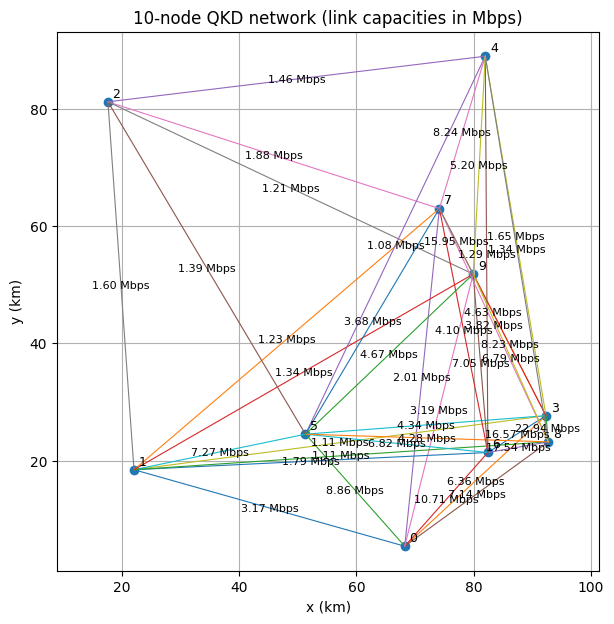

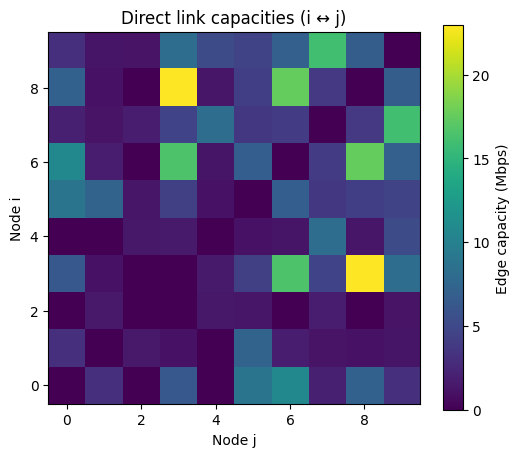

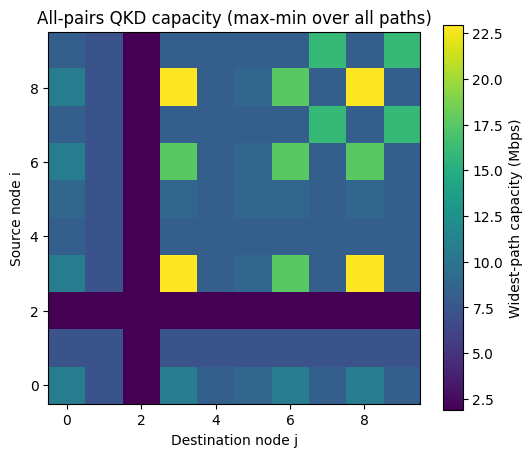

Direct link capacity matrix (Mbps):
[[ 0.     3.171  0.     6.359  0.     8.863 10.708  2.012  7.136  3.19 ]
 [ 3.171  0.     1.597  1.106  0.     7.271  1.789  1.232  1.108  1.336]
 [ 0.     1.597  0.     0.     1.462  1.388  0.     1.877  0.     1.213]
 [ 6.359  1.106  0.     0.     1.652  4.341 16.569  4.632 22.938  8.23 ]
 [ 0.     0.     1.462  1.652  0.     1.08   1.287  8.236  1.344  5.197]
 [ 8.863  7.271  1.388  4.341  1.08   0.     6.82   3.679  4.281  4.67 ]
 [10.708  1.789  0.    16.569  1.287  6.82   0.     4.095 17.535  7.055]
 [ 2.012  1.232  1.877  4.632  8.236  3.679  4.095  0.     3.823 15.951]
 [ 7.136  1.108  0.    22.938  1.344  4.281 17.535  3.823  0.     6.794]
 [ 3.19   1.336  1.213  8.23   5.197  4.67   7.055 15.951  6.794  0.   ]]

All-pairs widest-path capacity matrix (Mbps):
[[10.708  7.271  1.877 10.708  8.23   8.863 10.708  8.23  10.708  8.23 ]
 [ 7.271  7.271  1.877  7.271  7.271  7.271  7.271  7.271  7.271  7.271]
 [ 1.877  1.877  1.877  1.877  1.877  1.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# 0. PARAMETERS
# ==============================

# Physical / system parameters (ปรับเล่นได้)
MU             = 0.5        # mean photon number per pulse
ALPHA_DB_KM    = 0.2        # fiber loss (dB/km)
DET_EFF        = 0.15       # detector efficiency
DARK_PROB      = 1e-6       # dark count probability per pulse
MISALIGN_ERROR = 0.015      # intrinsic error (misalignment etc.)
PULSE_RATE     = 1e9        # pulses per second (เพื่อแปลงเป็น bit/s)

# Network parameters
N_NODES             = 10
AREA_SIZE_KM        = 100.0  # square area size (0..AREA_SIZE_KM) on x,y
MAX_LINK_DISTANCE_KM = 80.0  # ถ้า node ห่างกันมากกว่านี้จะไม่มีลิงก์

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)


# ==============================
# 1. BB84 KEY RATE MODEL (Analytic)
# ==============================

def binary_entropy(x):
    x = np.clip(x, 1e-12, 1 - 1e-12)
    return -x * np.log2(x) - (1 - x) * np.log2(1 - x)

def bb84_key_rate_per_pulse(distance_km):
    """
    คำนวณ BB84 asymptotic key rate ต่อ 'ส่งหนึ่ง pulse'
    (แบบ analytic ละ Monte Carlo เพื่อให้ใช้เร็วบน network)
    """
    if distance_km <= 0:
        distance_km = 1e-9

    # Channel transmittance
    transmittance = 10 ** (-ALPHA_DB_KM * distance_km / 10.0)

    # Effective detection efficiency
    eta = transmittance * DET_EFF

    # Signal detection probability
    p_signal = 1 - np.exp(-MU * eta)

    # Total detection probability (signal + dark)
    p_det = p_signal + DARK_PROB

    if p_det <= 0:
        return 0.0

    # QBER model:
    # misalignment contributes MISALIGN_ERROR on signal clicks
    # dark counts are random (error prob ~ 0.5)
    qber = (MISALIGN_ERROR * p_signal + 0.5 * DARK_PROB) / p_det

    # Sifted key fraction: ฐานตรงกันครึ่งหนึ่งของ detection ทั้งหมด
    sift_frac = 0.5 * p_det

    # Asymptotic secure key rate per pulse
    term = 1.0 - 2.0 * binary_entropy(qber)
    if term <= 0:
        return 0.0

    R_per_pulse = sift_frac * term
    return R_per_pulse  # [bits / pulse]


def bb84_key_rate_bps(distance_km):
    """แปลงเป็น bit/second ด้วยสมมติฐานว่า pulse rate คงที่."""
    return bb84_key_rate_per_pulse(distance_km) * PULSE_RATE


# ==============================
# 2. RANDOM 10-NODE TOPOLOGY
# ==============================

# สุ่มตำแหน่ง node บนแผนที่ 2D
positions = rng.random((N_NODES, 2)) * AREA_SIZE_KM   # (x,y) in km

# คำนวณระยะทาง pair-wise
dist_matrix = np.zeros((N_NODES, N_NODES))
for i in range(N_NODES):
    for j in range(N_NODES):
        dx = positions[i, 0] - positions[j, 0]
        dy = positions[i, 1] - positions[j, 1]
        dist_matrix[i, j] = np.sqrt(dx*dx + dy*dy)

# adjacency matrix ของ "ลิงก์ที่มีจริง" (1 ถ้ามี link)
adj_link = (dist_matrix > 0) & (dist_matrix <= MAX_LINK_DISTANCE_KM)


# ==============================
# 3. EDGE CAPACITY (KEY RATE) MATRIX
# ==============================

# capacity[i,j] = secure key rate (bit/s) ของลิงก์ระหว่าง i,j
capacity_matrix = np.zeros((N_NODES, N_NODES))

for i in range(N_NODES):
    for j in range(N_NODES):
        if i == j:
            continue
        if adj_link[i, j]:
            d = dist_matrix[i, j]
            rate = bb84_key_rate_bps(d)
            capacity_matrix[i, j] = rate
            capacity_matrix[j, i] = rate  # link symmetric


# ==============================
# 4. WIDEST-PATH ALL-PAIRS CAPACITY (MAX-MIN PATH)
# ==============================

def widest_path_all_pairs(capacity):
    """
    Floyd–Warshall แบบ max-min:
    cap_ij ใหม่ = max_over_k min(cap_ik, cap_kj)
    ได้ 'maximum bottleneck capacity' ระหว่างทุกคู่ i,j
    """
    n = capacity.shape[0]
    cap = capacity.copy()

    # self-capacity: กำหนดเป็น 0 (ไม่สำคัญในเครือข่ายนี้)
    np.fill_diagonal(cap, 0.0)

    for k in range(n):
        for i in range(n):
            if cap[i, k] == 0:
                continue
            for j in range(n):
                if cap[k, j] == 0:
                    continue
                via = min(cap[i, k], cap[k, j])
                if via > cap[i, j]:
                    cap[i, j] = via
    return cap

all_pairs_capacity = widest_path_all_pairs(capacity_matrix)


# ==============================
# 5. PLOTS
# ==============================

# --- Plot 1: network topology + link capacities ---
plt.figure(figsize=(7, 7))
x = positions[:, 0]
y = positions[:, 1]
plt.scatter(x, y)

for i in range(N_NODES):
    plt.text(x[i] + 0.8, y[i] + 0.8, f"{i}", fontsize=9)

# วาดเส้นสำหรับลิงก์ที่มีจริง
for i in range(N_NODES):
    for j in range(i + 1, N_NODES):
        if adj_link[i, j]:
            plt.plot([x[i], x[j]], [y[i], y[j]], linewidth=0.8)
            mid_x = 0.5 * (x[i] + x[j])
            mid_y = 0.5 * (y[i] + y[j])
            rate_mbps = capacity_matrix[i, j] / 1e6
            plt.text(mid_x, mid_y,
                     f"{rate_mbps:.2f} Mbps",
                     fontsize=8, ha='center', va='center')

plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.title("10-node QKD network (link capacities in Mbps)")
plt.grid(True)
plt.axis("equal")
plt.show()


# --- Plot 2: heatmap ของ edge capacity (ตรง ๆ) ---
plt.figure(figsize=(6, 5))
plt.imshow(capacity_matrix / 1e6, origin='lower')
plt.colorbar(label="Edge capacity (Mbps)")
plt.xlabel("Node j")
plt.ylabel("Node i")
plt.title("Direct link capacities (i ↔ j)")
plt.show()


# --- Plot 3: heatmap ของ all-pairs widest-path capacity ---
plt.figure(figsize=(6, 5))
plt.imshow(all_pairs_capacity / 1e6, origin='lower')
plt.colorbar(label="Widest-path capacity (Mbps)")
plt.xlabel("Destination node j")
plt.ylabel("Source node i")
plt.title("All-pairs QKD capacity (max-min over all paths)")
plt.show()


# ==============================
# 6. แสดงผลตัวเลขบางส่วน (optional)
# ==============================
print("Direct link capacity matrix (Mbps):")
print(np.round(capacity_matrix / 1e6, 3))

print("\nAll-pairs widest-path capacity matrix (Mbps):")
print(np.round(all_pairs_capacity / 1e6, 3))

In [4]:
# ==============================
# EXTRA CELL: centrality analysis
# ==============================
import numpy as np

# ---- 1) Degree centrality ----
# degree = จำนวนลิงก์ที่ต่อกับ node นั้น
degrees = adj_link.sum(axis=1)          # degree "ดิบ"
degree_centrality = degrees / (N_NODES - 1)   # normalize เป็น [0,1]

# ---- 2) Betweenness centrality (unweighted Brandes algorithm) ----
# ใช้โครงสร้าง topology (adj_link) อย่างเดียว
betweenness = np.zeros(N_NODES, dtype=float)

neighbors = {i: list(np.where(adj_link[i])[0]) for i in range(N_NODES)}

for s in range(N_NODES):
    stack = []
    pred = [[] for _ in range(N_NODES)]

    # จำนวน shortest paths จาก s ไป v
    sigma = np.zeros(N_NODES, dtype=float)
    sigma[s] = 1.0

    # ระยะทางจาก s ไป v (unweighted → จำนวน hop)
    dist = -np.ones(N_NODES, dtype=int)
    dist[s] = 0

    # BFS queue
    queue = [s]
    while queue:
        v = queue.pop(0)
        stack.append(v)
        for w in neighbors[v]:
            # เจอครั้งแรก
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                queue.append(w)
            # พบ shortest path อีกเส้นผ่าน v → w
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                pred[w].append(v)

    # dependency accumulation
    delta = np.zeros(N_NODES, dtype=float)
    while stack:
        w = stack.pop()
        for v in pred[w]:
            if sigma[w] > 0:
                delta_v = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                delta[v] += delta_v
        if w != s:
            betweenness[w] += delta[w]

# normalize (undirected graph)
if N_NODES > 2:
    betweenness /= ((N_NODES - 1) * (N_NODES - 2) / 2.0)

# ---- 3) match กับ capacity: avg incident capacity ของแต่ละ node ----
avg_incident_capacity = np.zeros(N_NODES)
for i in range(N_NODES):
    caps = capacity_matrix[i, :]
    caps = caps[caps > 0]  # เอาเฉพาะลิงก์ที่มีจริง
    if len(caps) > 0:
        avg_incident_capacity[i] = np.mean(caps) / 1e6  # Mbps
    else:
        avg_incident_capacity[i] = 0.0

# ---- 4) แสดงผลรวมในตาราง ----
print("Node | degree | degree_centrality | betweenness | avg_incident_capacity (Mbps)")
print("-----+--------+-------------------+------------+-----------------------------")
for i in range(N_NODES):
    print(f"{i:4d} |"
          f" {int(degrees[i]):6d} |"
          f" {degree_centrality[i]:17.3f} |"
          f" {betweenness[i]:10.3f} |"
          f" {avg_incident_capacity[i]:27.3f}")

# ---- 5) เรียงตาม betweenness สูงสุด (ใครเป็นคอขวดสุด) ----
sorted_idx = np.argsort(-betweenness)
print("\nNodes sorted by betweenness centrality (desc):")
for rank, i in enumerate(sorted_idx, start=1):
    print(f"{rank:2d}. node {i}  "
          f"(betweenness={betweenness[i]:.3f}, "
          f"deg_cen={degree_centrality[i]:.3f}, "
          f"avg_cap={avg_incident_capacity[i]:.2f} Mbps)")

Node | degree | degree_centrality | betweenness | avg_incident_capacity (Mbps)
-----+--------+-------------------+------------+-----------------------------
   0 |      7 |             0.778 |      0.000 |                       5.920
   1 |      8 |             0.889 |      0.047 |                       2.326
   2 |      5 |             0.556 |      0.008 |                       1.507
   3 |      8 |             0.889 |      0.017 |                       8.228
   4 |      7 |             0.778 |      0.033 |                       2.894
   5 |      9 |             1.000 |      0.064 |                       4.710
   6 |      8 |             0.889 |      0.017 |                       8.232
   7 |      9 |             1.000 |      0.064 |                       5.060
   8 |      8 |             0.889 |      0.017 |                       8.120
   9 |      9 |             1.000 |      0.064 |                       5.959

Nodes sorted by betweenness centrality (desc):
 1. node 5  (betweenness=

In [5]:
# ==============================
# EXTRA CELL: simulate node failure
# ==============================

def simulate_node_failure(fail_node, capacity_matrix, all_pairs_capacity):
    """
    ล้ม node = fail_node แล้วคำนวณ widest-path capacity ใหม่
    จากนั้นดูว่า pair ไหนโดนผลกระทบหนักสุด
    """
    print(f"\n=== Simulate failure of node {fail_node} ===")

    # 1) สร้าง capacity matrix ใหม่ โดยลบ node นี้ออกจาก network
    cap_mod = capacity_matrix.copy()
    cap_mod[fail_node, :] = 0.0
    cap_mod[:, fail_node] = 0.0

    # 2) คำนวณ widest-path all-pairs capacity ใหม่
    new_all_pairs = widest_path_all_pairs(cap_mod)

    # 3) ดูความแตกต่างก่อน-หลัง
    delta = all_pairs_capacity - new_all_pairs

    # คู่ที่เดิมมี capacity แต่ตอนนี้หายไปหมด (disconnect)
    was_connected = all_pairs_capacity > 0
    now_disconnected = (new_all_pairs == 0) & was_connected

    num_disconnected_pairs = np.sum(now_disconnected)
    print(f"Number of ordered pairs that become disconnected: {num_disconnected_pairs}")

    # 4) หา top-K คู่ที่ capacity ดรอปหนักสุด
    K = 10
    drops = []
    n = capacity_matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            drop = delta[i, j]
            if drop > 0:
                drops.append((drop, i, j))

    # เรียงจาก drop มาก → น้อย
    drops.sort(reverse=True, key=lambda x: x[0])

    print(f"\nTop {K} ordered pairs with largest capacity drop (before -> after, Mbps):")
    for k, (drop, i, j) in enumerate(drops[:K], start=1):
        before = all_pairs_capacity[i, j] / 1e6
        after  = new_all_pairs[i, j] / 1e6
        print(f"{k:2d}. {i} -> {j}:  {before:.3f} -> {after:.3f}  (drop {drop/1e6:.3f} Mbps)")

    return new_all_pairs, cap_mod


# ---- รันทดสอบ: ล้ม node 5 (betweenness สูง) ----
new_all_pairs_5, cap_mod_5 = simulate_node_failure(5, capacity_matrix, all_pairs_capacity)

# ---- รันทดสอบ: ล้ม node 0 (betweenness = 0) ----
new_all_pairs_0, cap_mod_0 = simulate_node_failure(0, capacity_matrix, all_pairs_capacity)


=== Simulate failure of node 5 ===
Number of ordered pairs that become disconnected: 19

Top 10 ordered pairs with largest capacity drop (before -> after, Mbps):
 1. 0 -> 5:  8.863 -> 0.000  (drop 8.863 Mbps)
 2. 3 -> 5:  8.863 -> 0.000  (drop 8.863 Mbps)
 3. 5 -> 0:  8.863 -> 0.000  (drop 8.863 Mbps)
 4. 5 -> 3:  8.863 -> 0.000  (drop 8.863 Mbps)
 5. 5 -> 6:  8.863 -> 0.000  (drop 8.863 Mbps)
 6. 5 -> 8:  8.863 -> 0.000  (drop 8.863 Mbps)
 7. 6 -> 5:  8.863 -> 0.000  (drop 8.863 Mbps)
 8. 8 -> 5:  8.863 -> 0.000  (drop 8.863 Mbps)
 9. 4 -> 5:  8.230 -> 0.000  (drop 8.230 Mbps)
10. 5 -> 4:  8.230 -> 0.000  (drop 8.230 Mbps)

=== Simulate failure of node 0 ===
Number of ordered pairs that become disconnected: 19

Top 10 ordered pairs with largest capacity drop (before -> after, Mbps):
 1. 0 -> 3:  10.708 -> 0.000  (drop 10.708 Mbps)
 2. 0 -> 6:  10.708 -> 0.000  (drop 10.708 Mbps)
 3. 0 -> 8:  10.708 -> 0.000  (drop 10.708 Mbps)
 4. 3 -> 0:  10.708 -> 0.000  (drop 10.708 Mbps)
 5. 6 ->

In [6]:
# ==============================
# EXTRA CELL: impact on OTHER nodes only
# ==============================

def analyze_failure_excluding_node(fail_node, all_pairs_before, capacity_matrix):
    """
    วิเคราะห์ผลกระทบของการล้ม node โดยดูเฉพาะคู่ (i,j) ที่ i,j != fail_node
    """
    print(f"\n=== Impact of failing node {fail_node} (excluding pairs with {fail_node}) ===")
    
    # สร้าง capacity matrix ใหม่
    cap_mod = capacity_matrix.copy()
    cap_mod[fail_node, :] = 0.0
    cap_mod[:, fail_node] = 0.0
    
    # คำนวณ widest-path ใหม่
    new_all_pairs = widest_path_all_pairs(cap_mod)
    
    # ต่างกันเท่าไร
    delta = all_pairs_before - new_all_pairs
    
    n = all_pairs_before.shape[0]
    drops_other = []
    disconnected_other = 0
    
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            # ข้ามคู่ที่เกี่ยวกับ node ที่ล้ม
            if i == fail_node or j == fail_node:
                continue
            
            before = all_pairs_before[i, j]
            after  = new_all_pairs[i, j]
            
            # เดิมต่อได้ แต่ตอนนี้ขาด
            if before > 0 and after == 0:
                disconnected_other += 1
            
            drop = before - after
            if drop > 0:
                drops_other.append((drop, i, j, before, after))
    
    print(f"Number of ordered pairs (i,j != {fail_node}) that become disconnected: {disconnected_other}")
    
    # เรียงคู่ที่ drop หนักสุด
    drops_other.sort(reverse=True, key=lambda x: x[0])
    K = min(10, len(drops_other))
    print(f"\nTop {K} affected pairs (excluding {fail_node}):")
    for rank, (drop, i, j, before, after) in enumerate(drops_other[:K], start=1):
        print(f"{rank:2d}. {i} -> {j}: {before/1e6:.3f} -> {after/1e6:.3f} Mbps "
              f"(drop {drop/1e6:.3f})")
    
    return new_all_pairs, cap_mod


# ---- วิเคราะห์ผลกระทบจริง ๆ ต่อ node อื่น ----
_ = analyze_failure_excluding_node(5, all_pairs_capacity, capacity_matrix)
_ = analyze_failure_excluding_node(0, all_pairs_capacity, capacity_matrix)


=== Impact of failing node 5 (excluding pairs with 5) ===
Number of ordered pairs (i,j != 5) that become disconnected: 0

Top 10 affected pairs (excluding 5):
 1. 0 -> 1: 7.271 -> 3.171 Mbps (drop 4.100)
 2. 1 -> 0: 7.271 -> 3.171 Mbps (drop 4.100)
 3. 1 -> 3: 7.271 -> 3.171 Mbps (drop 4.100)
 4. 1 -> 4: 7.271 -> 3.171 Mbps (drop 4.100)
 5. 1 -> 6: 7.271 -> 3.171 Mbps (drop 4.100)
 6. 1 -> 7: 7.271 -> 3.171 Mbps (drop 4.100)
 7. 1 -> 8: 7.271 -> 3.171 Mbps (drop 4.100)
 8. 1 -> 9: 7.271 -> 3.171 Mbps (drop 4.100)
 9. 3 -> 1: 7.271 -> 3.171 Mbps (drop 4.100)
10. 4 -> 1: 7.271 -> 3.171 Mbps (drop 4.100)

=== Impact of failing node 0 (excluding pairs with 0) ===
Number of ordered pairs (i,j != 0) that become disconnected: 0

Top 10 affected pairs (excluding 0):
 1. 3 -> 5: 8.863 -> 6.820 Mbps (drop 2.042)
 2. 5 -> 3: 8.863 -> 6.820 Mbps (drop 2.042)
 3. 5 -> 6: 8.863 -> 6.820 Mbps (drop 2.042)
 4. 5 -> 8: 8.863 -> 6.820 Mbps (drop 2.042)
 5. 6 -> 5: 8.863 -> 6.820 Mbps (drop 2.042)
 6. 8

Pearson corr(degree, impact)     = 0.345
Pearson corr(betweenness, impact) = 0.226


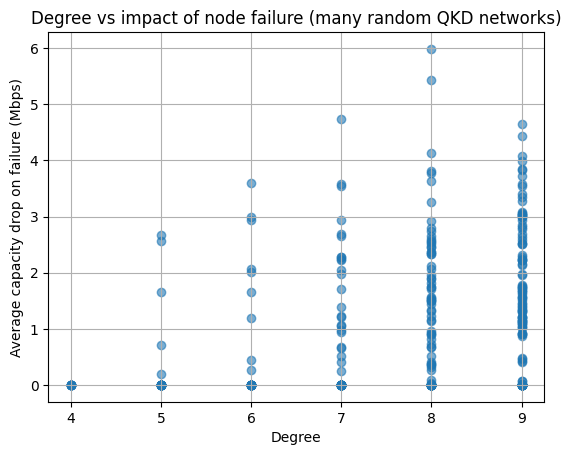

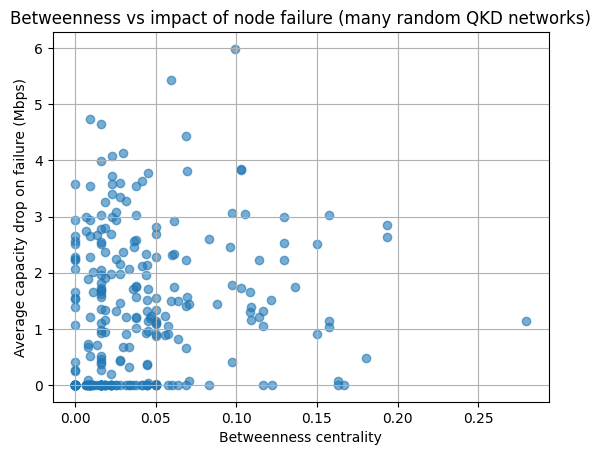

In [7]:
# ==============================
# EXTRA CELL: many random networks, statistics
# ==============================
import numpy as np
import matplotlib.pyplot as plt

NUM_NETWORKS = 30   # จำนวน topology สุ่ม (เพิ่มได้ถ้าอยากเนียนขึ้น)

all_degrees   = []
all_betweens  = []
all_impacts   = []   # average capacity drop on failure (Mbps)


def compute_betweenness(adj_link):
    """Betweenness centrality (unweighted, undirected Brandes algorithm)."""
    n = adj_link.shape[0]
    bet = np.zeros(n, dtype=float)
    neighbors = {i: list(np.where(adj_link[i])[0]) for i in range(n)}

    for s in range(n):
        stack = []
        pred = [[] for _ in range(n)]
        sigma = np.zeros(n, dtype=float)
        sigma[s] = 1.0
        dist = -np.ones(n, dtype=int)
        dist[s] = 0

        queue = [s]
        while queue:
            v = queue.pop(0)
            stack.append(v)
            for w in neighbors[v]:
                if dist[w] < 0:
                    dist[w] = dist[v] + 1
                    queue.append(w)
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)

        delta = np.zeros(n, dtype=float)
        while stack:
            w = stack.pop()
            for v in pred[w]:
                if sigma[w] > 0:
                    delta_v = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                    delta[v] += delta_v
            if w != s:
                bet[w] += delta[w]

    if n > 2:
        bet /= ((n - 1) * (n - 2) / 2.0)

    return bet


def node_failure_impact(fail_node, all_pairs_before, capacity_matrix):
    """
    impact = average absolute capacity drop (Mbps) บนคู่ (i,j)
    ที่ไม่ใช่ fail_node และเดิมเชื่อมถึง (before > 0)
    """
    cap_mod = capacity_matrix.copy()
    cap_mod[fail_node, :] = 0.0
    cap_mod[:, fail_node] = 0.0

    new_all_pairs = widest_path_all_pairs(cap_mod)
    n = all_pairs_before.shape[0]

    drops = []

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if i == fail_node or j == fail_node:
                continue
            before = all_pairs_before[i, j]
            after = new_all_pairs[i, j]
            if before > 0:
                drop = (before - after) / 1e6  # Mbps
                if drop > 0:
                    drops.append(drop)

    if len(drops) == 0:
        return 0.0
    return float(np.mean(drops))


for net_seed in range(NUM_NETWORKS):
    # ----- สร้าง topology สุ่มใหม่ -----
    rng = np.random.default_rng(1000 + net_seed)

    positions = rng.random((N_NODES, 2)) * AREA_SIZE_KM
    dist_matrix = np.zeros((N_NODES, N_NODES))

    for i in range(N_NODES):
        for j in range(N_NODES):
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]
            dist_matrix[i, j] = np.sqrt(dx*dx + dy*dy)

    adj_link = (dist_matrix > 0) & (dist_matrix <= MAX_LINK_DISTANCE_KM)

    # ถ้า network ขาดเป็นหลาย component มากไป อาจข้าม topology นี้
    if np.all(adj_link.sum(axis=1) == 0):
        continue

    capacity_matrix = np.zeros((N_NODES, N_NODES))

    for i in range(N_NODES):
        for j in range(i+1, N_NODES):
            if adj_link[i, j]:
                d = dist_matrix[i, j]
                rate = bb84_key_rate_bps(d)
                capacity_matrix[i, j] = rate
                capacity_matrix[j, i] = rate

    all_pairs_before = widest_path_all_pairs(capacity_matrix)
    bet = compute_betweenness(adj_link)
    deg = adj_link.sum(axis=1)

    # ----- impact ของแต่ละ node ใน topology นี้ -----
    for node in range(N_NODES):
        impact = node_failure_impact(node, all_pairs_before, capacity_matrix)
        all_degrees.append(deg[node])
        all_betweens.append(bet[node])
        all_impacts.append(impact)

all_degrees  = np.array(all_degrees, dtype=float)
all_betweens = np.array(all_betweens, dtype=float)
all_impacts  = np.array(all_impacts, dtype=float)

# ----- คำนวณ correlation -----
def pearson_corr(x, y):
    if len(x) < 2:
        return np.nan
    xm = x - x.mean()
    ym = y - y.mean()
    denom = np.sqrt((xm**2).sum() * (ym**2).sum())
    if denom == 0:
        return np.nan
    return float((xm * ym).sum() / denom)

corr_deg = pearson_corr(all_degrees, all_impacts)
corr_bet = pearson_corr(all_betweens, all_impacts)

print(f"Pearson corr(degree, impact)     = {corr_deg:.3f}")
print(f"Pearson corr(betweenness, impact) = {corr_bet:.3f}")

# ----- Plot: degree vs impact -----
plt.figure()
plt.scatter(all_degrees, all_impacts, alpha=0.6)
plt.xlabel("Degree")
plt.ylabel("Average capacity drop on failure (Mbps)")
plt.title("Degree vs impact of node failure (many random QKD networks)")
plt.grid(True)
plt.show()

# ----- Plot: betweenness vs impact -----
plt.figure()
plt.scatter(all_betweens, all_impacts, alpha=0.6)
plt.xlabel("Betweenness centrality")
plt.ylabel("Average capacity drop on failure (Mbps)")
plt.title("Betweenness vs impact of node failure (many random QKD networks)")
plt.grid(True)
plt.show()

Initial global capacity T(0) = 657.940 Mbps


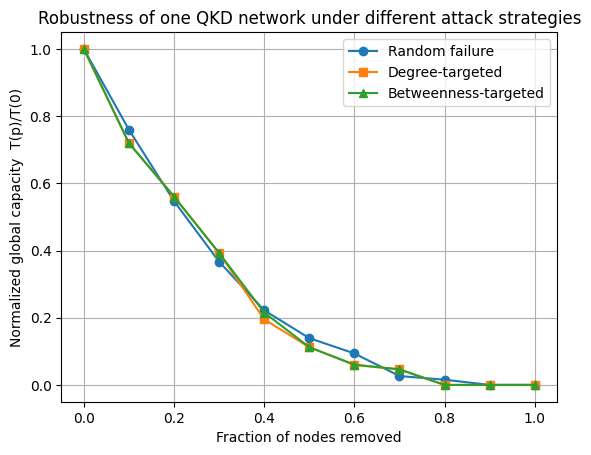

In [8]:
# ==============================
# ROBUSTNESS CURVE FOR ONE QKD NETWORK
# ==============================
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(2025)

# ---------- helper: betweenness (unweighted, undirected) ----------
def compute_betweenness(adj_link):
    n = adj_link.shape[0]
    bet = np.zeros(n, dtype=float)
    neighbors = {i: list(np.where(adj_link[i])[0]) for i in range(n)}

    for s in range(n):
        stack = []
        pred = [[] for _ in range(n)]
        sigma = np.zeros(n, dtype=float)
        sigma[s] = 1.0
        dist = -np.ones(n, dtype=int)
        dist[s] = 0

        queue = [s]
        while queue:
            v = queue.pop(0)
            stack.append(v)
            for w in neighbors[v]:
                if dist[w] < 0:
                    dist[w] = dist[v] + 1
                    queue.append(w)
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)

        delta = np.zeros(n, dtype=float)
        while stack:
            w = stack.pop()
            for v in pred[w]:
                if sigma[w] > 0:
                    delta_v = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                    delta[v] += delta_v
            if w != s:
                bet[w] += delta[w]

    if n > 2:
        bet /= ((n - 1) * (n - 2) / 2.0)
    return bet

# ---------- helper: build one random QKD network ----------
def build_random_qkd_network(seed=None):
    if seed is not None:
        local_rng = np.random.default_rng(seed)
    else:
        local_rng = np.random.default_rng()

    positions = local_rng.random((N_NODES, 2)) * AREA_SIZE_KM

    dist_matrix = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(N_NODES):
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]
            dist_matrix[i, j] = np.sqrt(dx*dx + dy*dy)

    adj_link = (dist_matrix > 0) & (dist_matrix <= MAX_LINK_DISTANCE_KM)

    capacity_matrix = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(i+1, N_NODES):
            if adj_link[i, j]:
                d = dist_matrix[i, j]
                rate = bb84_key_rate_bps(d)  # bit/s
                capacity_matrix[i, j] = rate
                capacity_matrix[j, i] = rate

    return positions, dist_matrix, adj_link, capacity_matrix

# ---------- helper: global capacity T ----------
def global_capacity(all_pairs_capacity):
    # ใช้ sum ทั้ง matrix (ordered pairs) แล้วแปลงเป็น Mbps
    return np.sum(all_pairs_capacity) / 1e6

# ---------- robustness curve for one strategy ----------
def robustness_curve(capacity_matrix_init, strategy, seed=None):
    """
    strategy: 'random', 'degree', 'betweenness'
    adaptive: คำนวณ degree/betweenness ใหม่ทุกครั้งหลังล้มโหนด
    """
    n = capacity_matrix_init.shape[0]
    cap_cur = capacity_matrix_init.copy()
    active = np.ones(n, dtype=bool)

    # adjacency ปัจจุบันจะ derive จาก cap_cur > 0
    def current_adj():
        A = (cap_cur > 0).astype(int)
        np.fill_diagonal(A, 0)
        return A

    # ลำดับสุ่มสำหรับ random strategy
    if seed is not None:
        local_rng = np.random.default_rng(seed)
    else:
        local_rng = np.random.default_rng()
    random_order = local_rng.permutation(n).tolist()
    random_idx = 0

    capacities = []

    # step k = 0..n (จำนวนโหนดที่ล้มแล้ว)
    for k in range(n+1):
        # 1) คำนวณ global capacity ณ สถานะปัจจุบัน
        all_pairs = widest_path_all_pairs(cap_cur)
        T = global_capacity(all_pairs)
        capacities.append(T)

        if k == n:
            break  # ไม่มีโหนดเหลือให้ล้มแล้ว

        # 2) เลือกโหนดที่จะล้มต่อไป
        adj = current_adj()

        if strategy == 'random':
            # ข้าม node ที่ถูกล้มไปแล้ว
            while random_idx < n and not active[random_order[random_idx]]:
                random_idx += 1
            if random_idx >= n:
                break
            v = random_order[random_idx]

        elif strategy == 'degree':
            degrees = adj.sum(axis=1)
            degrees[~active] = -1  # ไม่เลือก inactive
            v = int(np.argmax(degrees))

        elif strategy == 'betweenness':
            bet = compute_betweenness(adj)
            bet[~active] = -1
            v = int(np.argmax(bet))

        else:
            raise ValueError("unknown strategy")

        # 3) ล้มโหนด v: ล้างแถว/คอลัมน์ออกจาก cap_cur
        active[v] = False
        cap_cur[v, :] = 0.0
        cap_cur[:, v] = 0.0

    capacities = np.array(capacities)
    return capacities

# ==============================
# RUN EXPERIMENT ON ONE TOPOLOGY
# ==============================

# สร้าง topology หนึ่งชุด
positions, dist_matrix, adj_link, capacity_matrix = build_random_qkd_network(seed=777)

# baseline capacity (ก่อนล้มโหนด)
all_pairs_0 = widest_path_all_pairs(capacity_matrix)
T0 = global_capacity(all_pairs_0)
print(f"Initial global capacity T(0) = {T0:.3f} Mbps")

# robustness curves
cap_random = robustness_curve(capacity_matrix, 'random',      seed=123)
cap_degree = robustness_curve(capacity_matrix, 'degree')
cap_bet    = robustness_curve(capacity_matrix, 'betweenness')

# ทำให้เป็น normalized T(p)/T(0)
T0 = cap_random[0]  # ทุกเส้นควรเท่ากัน
x = np.arange(len(cap_random)) / (len(cap_random) - 1)  # fraction of nodes removed

y_random = cap_random / T0
y_degree = cap_degree / T0
y_bet    = cap_bet    / T0

# ==============================
# PLOT ROBUSTNESS CURVE
# ==============================
plt.figure()
plt.plot(x, y_random, marker='o', label="Random failure")
plt.plot(x, y_degree, marker='s', label="Degree-targeted")
plt.plot(x, y_bet,    marker='^', label="Betweenness-targeted")
plt.xlabel("Fraction of nodes removed")
plt.ylabel("Normalized global capacity  T(p)/T(0)")
plt.title("Robustness of one QKD network under different attack strategies")
plt.grid(True)
plt.legend()
plt.show()

Initial global capacity T(0) = 738.090 Mbps


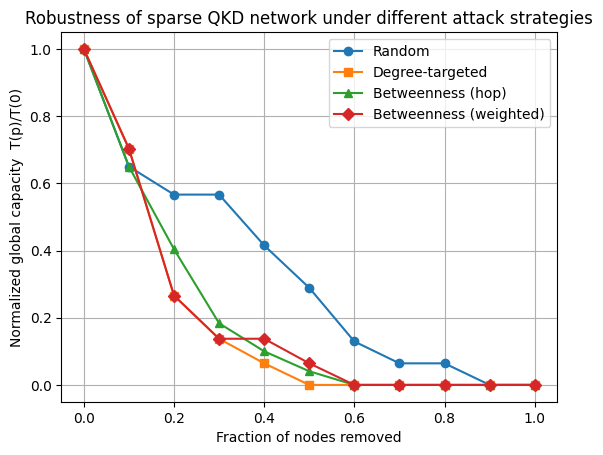

In [9]:
# ============================================
# ROBUSTNESS CURVE (WEIGHTED BETWEENNESS + ADAPTIVE)
# ============================================
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(4242)

# ใช้ threshold ที่เล็กลงให้ network ไม่หนาเกินไป
MAX_LINK_DISTANCE_KM_EXP = 40.0  # ปรับได้ถ้าอยาก sparse/หนา

# ---------- helper: build sparse QKD network ----------
def build_random_qkd_network_sparse(seed=None):
    if seed is not None:
        local_rng = np.random.default_rng(seed)
    else:
        local_rng = np.random.default_rng()

    positions = local_rng.random((N_NODES, 2)) * AREA_SIZE_KM

    dist_matrix = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(N_NODES):
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]
            dist_matrix[i, j] = np.sqrt(dx*dx + dy*dy)

    adj_link = (dist_matrix > 0) & (dist_matrix <= MAX_LINK_DISTANCE_KM_EXP)

    capacity_matrix = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(i+1, N_NODES):
            if adj_link[i, j]:
                d = dist_matrix[i, j]
                rate = bb84_key_rate_bps(d)  # bit/s
                capacity_matrix[i, j] = rate
                capacity_matrix[j, i] = rate

    return positions, dist_matrix, adj_link, capacity_matrix

# ---------- unweighted betweenness (hop) ----------
def compute_betweenness_unweighted(adj_link):
    n = adj_link.shape[0]
    bet = np.zeros(n, dtype=float)
    neighbors = {i: list(np.where(adj_link[i])[0]) for i in range(n)}

    for s in range(n):
        stack = []
        pred = [[] for _ in range(n)]
        sigma = np.zeros(n, dtype=float); sigma[s] = 1.0
        dist = -np.ones(n, dtype=int); dist[s] = 0

        queue = [s]
        while queue:
            v = queue.pop(0)
            stack.append(v)
            for w in neighbors[v]:
                if dist[w] < 0:
                    dist[w] = dist[v] + 1
                    queue.append(w)
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)

        delta = np.zeros(n, dtype=float)
        while stack:
            w = stack.pop()
            for v in pred[w]:
                if sigma[w] > 0:
                    delta_v = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                    delta[v] += delta_v
            if w != s:
                bet[w] += delta[w]

    if n > 2:
        bet /= ((n - 1) * (n - 2) / 2.0)
    return bet

# ---------- weighted betweenness (Dijkstra-based Brandes) ----------
def compute_betweenness_weighted(capacity_matrix):
    """
    ใช้ weight = 1/capacity (capacity สูง = น้ำหนัก/ระยะสั้น)
    ไม่มีลิงก์ = weight = inf
    """
    n = capacity_matrix.shape[0]
    bet = np.zeros(n, dtype=float)

    # สร้าง weight matrix
    W = np.full((n, n), np.inf)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            cap = capacity_matrix[i, j]
            if cap > 0:
                W[i, j] = 1.0 / cap

    for s in range(n):
        S = []
        P = [[] for _ in range(n)]
        sigma = np.zeros(n, dtype=float); sigma[s] = 1.0
        dist = np.full(n, np.inf); dist[s] = 0.0

        # ดำเนินการแบบ Dijkstra อย่างง่าย
        visited = np.zeros(n, dtype=bool)

        for _ in range(n):
            # เลือก node ที่ยังไม่ visited และ dist ต่ำสุด
            u = -1
            best = np.inf
            for v in range(n):
                if not visited[v] and dist[v] < best:
                    best = dist[v]
                    u = v
            if u == -1:
                break
            visited[u] = True
            S.append(u)

            # relax เพื่อนบ้านทั้งหมด
            for v in range(n):
                w_uv = W[u, v]
                if np.isinf(w_uv):
                    continue
                alt = dist[u] + w_uv
                if alt < dist[v] - 1e-15:
                    dist[v] = alt
                    sigma[v] = sigma[u]
                    P[v] = [u]
                elif abs(alt - dist[v]) <= 1e-15 and sigma[u] > 0:
                    sigma[v] += sigma[u]
                    P[v].append(u)

        # accumulate dependencies
        delta = np.zeros(n, dtype=float)
        while S:
            w = S.pop()
            for v in P[w]:
                if sigma[w] > 0:
                    delta_v = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                    delta[v] += delta_v
            if w != s:
                bet[w] += delta[w]

    if n > 2:
        bet /= ((n - 1) * (n - 2) / 2.0)
    return bet

# ---------- global capacity ----------
def global_capacity(all_pairs_capacity):
    return np.sum(all_pairs_capacity) / 1e6  # Mbps

# ---------- robustness curve with multiple strategies ----------
def robustness_curve_adv(capacity_matrix_init, strategy, seed=None):
    """
    strategy:
      'random'             - random node removal
      'degree'             - adaptive degree-targeted
      'bet_unweighted'     - adaptive hop betweenness
      'bet_weighted'       - adaptive capacity-weighted betweenness
    """
    n = capacity_matrix_init.shape[0]
    cap_cur = capacity_matrix_init.copy()
    active = np.ones(n, dtype=bool)

    def current_adj():
        A = (cap_cur > 0).astype(int)
        np.fill_diagonal(A, 0)
        return A

    if seed is not None:
        local_rng = np.random.default_rng(seed)
    else:
        local_rng = np.random.default_rng()
    rand_order = local_rng.permutation(n).tolist()
    rand_idx = 0

    capacities = []

    for k in range(n + 1):
        all_pairs = widest_path_all_pairs(cap_cur)
        T = global_capacity(all_pairs)
        capacities.append(T)

        if k == n:
            break

        adj = current_adj()

        if strategy == 'random':
            while rand_idx < n and not active[rand_order[rand_idx]]:
                rand_idx += 1
            if rand_idx >= n:
                break
            v = int(rand_order[rand_idx])

        elif strategy == 'degree':
            deg = adj.sum(axis=1)
            deg[~active] = -1
            v = int(np.argmax(deg))

        elif strategy == 'bet_unweighted':
            bet = compute_betweenness_unweighted(adj)
            bet[~active] = -1
            v = int(np.argmax(bet))

        elif strategy == 'bet_weighted':
            bet_w = compute_betweenness_weighted(cap_cur)
            bet_w[~active] = -1
            v = int(np.argmax(bet_w))

        else:
            raise ValueError("unknown strategy")

        active[v] = False
        cap_cur[v, :] = 0.0
        cap_cur[:, v] = 0.0

    return np.array(capacities)

# ============================================
# RUN EXPERIMENT ON ONE SPARSE TOPOLOGY
# ============================================
positions, dist_matrix, adj_link, capacity_matrix = build_random_qkd_network_sparse(seed=999)

all_pairs_0 = widest_path_all_pairs(capacity_matrix)
T0 = global_capacity(all_pairs_0)
print(f"Initial global capacity T(0) = {T0:.3f} Mbps")

cap_random = robustness_curve_adv(capacity_matrix, 'random',        seed=123)
cap_degree = robustness_curve_adv(capacity_matrix, 'degree')
cap_bu     = robustness_curve_adv(capacity_matrix, 'bet_unweighted')
cap_bw     = robustness_curve_adv(capacity_matrix, 'bet_weighted')

x = np.arange(len(cap_random)) / (len(cap_random) - 1)
T0_norm = cap_random[0]

y_r  = cap_random / T0_norm
y_d  = cap_degree / T0_norm
y_bu = cap_bu     / T0_norm
y_bw = cap_bw     / T0_norm

plt.figure()
plt.plot(x, y_r,  marker='o', label="Random")
plt.plot(x, y_d,  marker='s', label="Degree-targeted")
plt.plot(x, y_bu, marker='^', label="Betweenness (hop)")
plt.plot(x, y_bw, marker='D', label="Betweenness (weighted)")
plt.xlabel("Fraction of nodes removed")
plt.ylabel("Normalized global capacity  T(p)/T(0)")
plt.title("Robustness of sparse QKD network under different attack strategies")
plt.grid(True)
plt.legend()
plt.show()

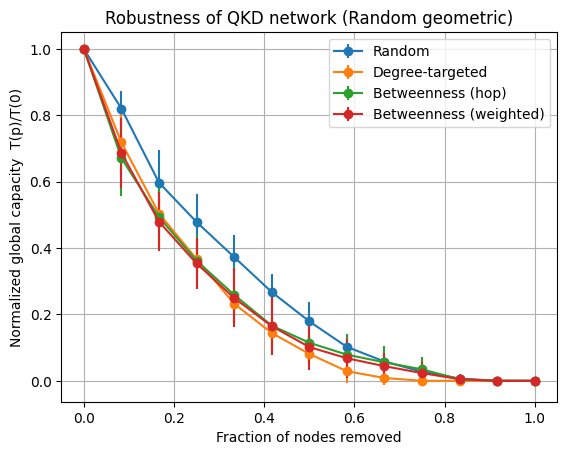

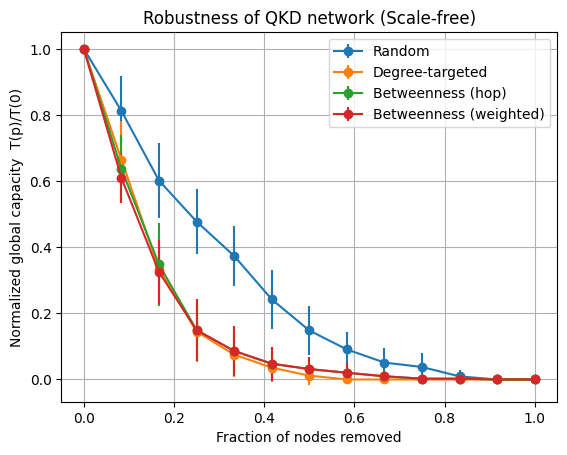

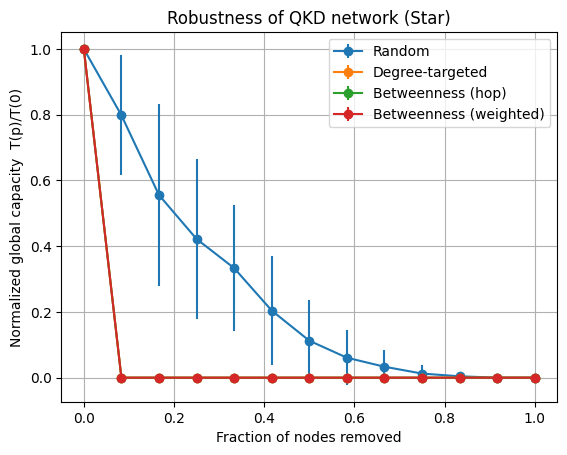

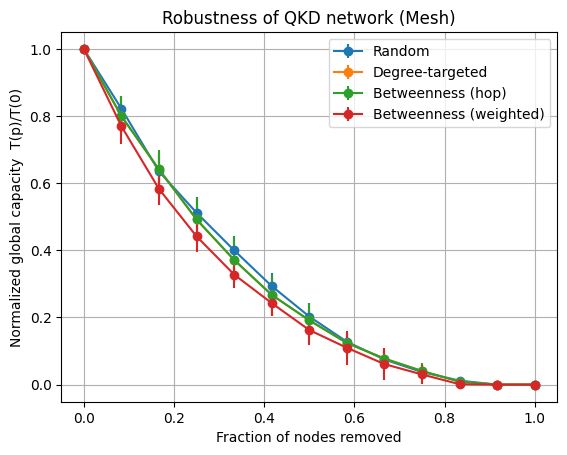

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# GLOBAL PARAMS
# =========================
N_NODES        = 12
AREA_SIZE_KM   = 100.0
ALPHA_DB_KM    = 0.2
MU             = 0.5
DET_EFF        = 0.15
DARK_PROB      = 1e-6
MISALIGN_ERROR = 0.015
PULSE_RATE     = 1e9     # pulses/s
NUM_NETS       = 20      # number of networks per topology

rng = np.random.default_rng(2025)

# =========================
# BB84 CAPACITY MODELadj, cap = builder(seed=1000 + net_idx)

# =========================
def binary_entropy(x):
    x = np.clip(x, 1e-12, 1-1e-12)
    return -x*np.log2(x) - (1-x)*np.log2(1-x)

def bb84_key_rate_per_pulse(distance_km):
    if distance_km <= 0:
        distance_km = 1e-9
    trans = 10**(-ALPHA_DB_KM * distance_km / 10)
    eta   = trans * DET_EFF
    p_sig = 1 - np.exp(-MU * eta)
    p_det = p_sig + DARK_PROB
    if p_det <= 0:
        return 0.0
    qber = (MISALIGN_ERROR * p_sig + 0.5 * DARK_PROB) / p_det
    sift = 0.5 * p_det
    term = 1 - 2*binary_entropy(qber)
    if term <= 0:
        return 0.0
    return sift * term

def bb84_key_rate_bps(distance_km):
    return bb84_key_rate_per_pulse(distance_km) * PULSE_RATE

# =========================
# WIDEST PATH (max-min)
# =========================
def widest_path_all_pairs(capacity):
    n = capacity.shape[0]
    cap = capacity.copy()
    np.fill_diagonal(cap, 0.0)
    for k in range(n):
        for i in range(n):
            if cap[i, k] == 0:
                continue
            for j in range(n):
                if cap[k, j] == 0:
                    continue
                via = min(cap[i, k], cap[k, j])
                if via > cap[i, j]:
                    cap[i, j] = via
    return cap

def global_capacity(all_pairs_capacity):
    return np.sum(all_pairs_capacity) / 1e6  # Mbps

# =========================
# CENTRALITY
# =========================
def compute_betweenness_unweighted(adj_link):
    n = adj_link.shape[0]
    bet = np.zeros(n, dtype=float)
    neighbors = {i: list(np.where(adj_link[i])[0]) for i in range(n)}
    for s in range(n):
        stack = []
        pred = [[] for _ in range(n)]
        sigma = np.zeros(n); sigma[s] = 1.0
        dist = -np.ones(n, dtype=int); dist[s] = 0
        q = [s]
        while q:
            v = q.pop(0)
            stack.append(v)
            for w in neighbors[v]:
                if dist[w] < 0:
                    dist[w] = dist[v] + 1
                    q.append(w)
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)
        delta = np.zeros(n)
        while stack:
            w = stack.pop()
            for v in pred[w]:
                if sigma[w] > 0:
                    delta_v = (sigma[v]/sigma[w])*(1+delta[w])
                    delta[v] += delta_v
            if w != s:
                bet[w] += delta[w]
    if n > 2:
        bet /= ((n-1)*(n-2)/2.0)
    return bet

def compute_betweenness_weighted(capacity_matrix):
    n = capacity_matrix.shape[0]
    bet = np.zeros(n, dtype=float)
    W = np.full((n, n), np.inf)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            cap = capacity_matrix[i, j]
            if cap > 0:
                W[i, j] = 1.0 / cap
    for s in range(n):
        S = []
        P = [[] for _ in range(n)]
        sigma = np.zeros(n); sigma[s] = 1.0
        dist = np.full(n, np.inf); dist[s] = 0.0
        visited = np.zeros(n, dtype=bool)
        for _ in range(n):
            u = -1; best = np.inf
            for v in range(n):
                if not visited[v] and dist[v] < best:
                    best = dist[v]; u = v
            if u == -1:
                break
            visited[u] = True
            S.append(u)
            for v in range(n):
                w_uv = W[u, v]
                if np.isinf(w_uv):
                    continue
                alt = dist[u] + w_uv
                if alt < dist[v] - 1e-15:
                    dist[v] = alt
                    sigma[v] = sigma[u]
                    P[v] = [u]
                elif abs(alt - dist[v]) <= 1e-15 and sigma[u] > 0:
                    sigma[v] += sigma[u]
                    P[v].append(u)
        delta = np.zeros(n)
        while S:
            w = S.pop()
            for v in P[w]:
                if sigma[w] > 0:
                    delta_v = (sigma[v]/sigma[w])*(1+delta[w])
                    delta[v] += delta_v
            if w != s:
                bet[w] += delta[w]
    if n > 2:
        bet /= ((n-1)*(n-2)/2.0)
    return bet

# =========================
# TOPOLOGY BUILDERS
# =========================
def build_random_geometric(seed=None, max_link_km=40.0):
    r = np.random.default_rng(seed)
    pos = r.random((N_NODES, 2))*AREA_SIZE_KM
    dist = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(N_NODES):
            dx = pos[i,0]-pos[j,0]; dy = pos[i,1]-pos[j,1]
            dist[i,j] = np.sqrt(dx*dx + dy*dy)
    adj = (dist > 0) & (dist <= max_link_km)
    cap = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(i+1, N_NODES):
            if adj[i,j]:
                rate = bb84_key_rate_bps(dist[i,j])
                cap[i,j] = cap[j,i] = rate
    return adj, cap

def build_scale_free(seed=None, max_link_km=60.0):
    r = np.random.default_rng(seed)
    pos = r.random((N_NODES, 2))*AREA_SIZE_KM
    dist = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(N_NODES):
            dx = pos[i,0]-pos[j,0]; dy = pos[i,1]-pos[j,1]
            dist[i,j] = np.sqrt(dx*dx + dy*dy)

    # BA model
    m0 = 3; m = 2
    adj = np.zeros((N_NODES, N_NODES), dtype=bool)
    # initial complete graph of m0 nodes
    for i in range(m0):
        for j in range(i+1, m0):
            adj[i,j] = adj[j,i] = True
    degree = adj.sum(axis=0).astype(float)
    for new in range(m0, N_NODES):
        probs = degree[:new] / degree[:new].sum()
        targets = r.choice(np.arange(new), size=m, replace=False, p=probs)
        for t in targets:
            adj[new, t] = adj[t, new] = True
        degree = adj.sum(axis=0).astype(float)

    cap = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(i+1, N_NODES):
            if adj[i,j]:
                # ใช้ระยะจริงแต่ตัดที่ max_link_km เพื่อไม่ให้ loss โหดเกิน
                d = min(dist[i,j], max_link_km)
                cap[i,j] = cap[j,i] = bb84_key_rate_bps(d)
    return adj, cap

def build_star(seed=None):
    r = np.random.default_rng(seed)
    # hub at node 0
    pos = np.zeros((N_NODES, 2))
    pos[0] = np.array([AREA_SIZE_KM/2, AREA_SIZE_KM/2])
    angles = np.linspace(0, 2*np.pi, N_NODES, endpoint=False)[1:]
    radius = AREA_SIZE_KM/3
    for k, node in enumerate(range(1, N_NODES)):
        pos[node] = pos[0] + radius*np.array([np.cos(angles[k]), np.sin(angles[k])])

    dist = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(N_NODES):
            dx = pos[i,0]-pos[j,0]; dy = pos[i,1]-pos[j,1]
            dist[i,j] = np.sqrt(dx*dx + dy*dy)

    adj = np.zeros((N_NODES, N_NODES), dtype=bool)
    for j in range(1, N_NODES):
        adj[0,j] = adj[j,0] = True

    cap = np.zeros((N_NODES, N_NODES))
    for j in range(1, N_NODES):
        d = dist[0,j]
        cap[0,j] = cap[j,0] = bb84_key_rate_bps(d)
    return adj, cap

def build_mesh(seed=None):
    r = np.random.default_rng(seed)
    pos = r.random((N_NODES, 2))*AREA_SIZE_KM
    dist = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(N_NODES):
            dx = pos[i,0]-pos[j,0]; dy = pos[i,1]-pos[j,1]
            dist[i,j] = np.sqrt(dx*dx + dy*dy)
    adj = np.ones((N_NODES, N_NODES), dtype=bool)
    np.fill_diagonal(adj, False)
    cap = np.zeros((N_NODES, N_NODES))
    for i in range(N_NODES):
        for j in range(i+1, N_NODES):
            cap[i,j] = cap[j,i] = bb84_key_rate_bps(dist[i,j])
    return adj, cap

# =========================
# ROBUSTNESS CURVE (ADVANCED)
# =========================
def robustness_curve_adv(capacity_init, strategy, seed=None):
    n = capacity_init.shape[0]
    cap_cur = capacity_init.copy()
    active = np.ones(n, dtype=bool)

    if seed is not None:
        r = np.random.default_rng(seed)
    else:
        r = np.random.default_rng()
    rand_order = r.permutation(n).tolist()
    rand_idx = 0

    capacities = []

    def current_adj():
        A = (cap_cur > 0).astype(int)
        np.fill_diagonal(A, 0)
        return A

    for k in range(n+1):
        all_pairs = widest_path_all_pairs(cap_cur)
        capacities.append(global_capacity(all_pairs))
        if k == n:
            break

        adj = current_adj()
        if strategy == "random":
            while rand_idx < n and not active[rand_order[rand_idx]]:
                rand_idx += 1
            if rand_idx >= n:
                break
            v = rand_order[rand_idx]

        elif strategy == "degree":
            deg = adj.sum(axis=1)
            deg[~active] = -1
            v = int(np.argmax(deg))

        elif strategy == "bet_hop":
            bet = compute_betweenness_unweighted(adj)
            bet[~active] = -1
            v = int(np.argmax(bet))

        elif strategy == "bet_weight":
            betw = compute_betweenness_weighted(cap_cur)
            betw[~active] = -1
            v = int(np.argmax(betw))

        else:
            raise ValueError("unknown strategy")

        active[v] = False
        cap_cur[v, :] = 0.0
        cap_cur[:, v] = 0.0

    return np.array(capacities)

# =========================
# MAIN EXPERIMENT
# =========================
topos = {
    "Random geometric": lambda s: build_random_geometric(seed=s, max_link_km=40.0),
    "Scale-free":       lambda s: build_scale_free(seed=s,       max_link_km=60.0),
    "Star":             lambda s: build_star(seed=s),
    "Mesh":             lambda s: build_mesh(seed=s),
}


strategies = ["random", "degree", "bet_hop", "bet_weight"]
labels     = {
    "random":     "Random",
    "degree":     "Degree-targeted",
    "bet_hop":    "Betweenness (hop)",
    "bet_weight": "Betweenness (weighted)",
}

x = np.arange(N_NODES+1) / N_NODES

for topo_name, builder in topos.items():
    curves = {s: [] for s in strategies}

    for net_idx in range(NUM_NETS):
        adj, cap = builder(1000 + net_idx)
        # ถ้า network ไม่มีลิงก์เลย ข้าม
        if np.all(cap == 0):
            continue

        # robustness per strategy
        base = robustness_curve_adv(cap, "random", seed=2000+net_idx)  # ใช้ค่าตอน k=0 เป็น baseline T(0)
        T0 = base[0]
        curves["random"].append(base / T0)

        for s in ["degree", "bet_hop", "bet_weight"]:
            c = robustness_curve_adv(cap, s)
            curves[s].append(c / T0)

    plt.figure()
    for s in strategies:
        arr = np.array(curves[s])
        mean = arr.mean(axis=0)
        std  = arr.std(axis=0)
        plt.errorbar(x, mean, yerr=std, marker='o', label=labels[s])
    plt.xlabel("Fraction of nodes removed")
    plt.ylabel("Normalized global capacity  T(p)/T(0)")
    plt.title(f"Robustness of QKD network ({topo_name})")
    plt.grid(True)
    plt.legend()
    plt.show()